In [177]:
import copy
import json
import os
import numpy as np
import kernel
import configuration
import calibration
from matplotlib import pyplot as plt

In [178]:
def test_data(c_path, w_path, e_path, json_path, offset=1, printing=True): 
    descriptors = np.loadtxt(c_path)
    weights = np.loadtxt(w_path)
    e_ave = np.loadtxt(e_path)[0]
    with open(json_path, 'r') as u_conf:
            user_config = json.load(u_conf)

    # make a list of the allowed qs
    qs = np.arange(1, user_config['nr_modi']+1) * np.pi / user_config['cutoff']

    # read in data and save parameters for calibration comparison
    (nc_new, ni_new, lat, configurations) = calibration.load_data(user_config, offset)

    config = configurations[0]
    
    if printing:
        for key, value in user_config.items():
            if type(value) != list:
                print(f'{key:>15}: {value:<15}')
            else:
                print(f'{key:>15}: {value[0]:<15}')
                print(f'{"sigma":>15}: {value[1]:<15}')

    nc_old = int(weights.size / 64)
    ni_old = 64

    kern = kernel.Kernel(*user_config['kernel'])

    config.init_nn(user_config['cutoff'], lat)
    config.init_descriptor(qs)

    E, F_reg = kern.predict(qs, config, descriptors, weights, e_ave)
    
    delta_F = F_reg - config.forces
    F_mean = np.mean(np.linalg.norm(delta_F, axis=1))
    F_var = np.var(np.linalg.norm(delta_F, axis=1))

    signs_reg = np.sign(F_reg)
    signs_ana = np.sign(config.forces)
    sign_diff = signs_reg - signs_ana
    
    if printing:
        print('\nPredicted values:')
        print(f'energy = {E}')
        print(f'forces = {F_reg[1]}\n')

        print('Values from Outcar:')
        print(f'energy = {config.energy}')
        print(f'forces = {config.forces[1]}')
        print('\nSign differences:', sign_diff[sign_diff != 0].size, 'out of', sign_diff.size)
        #print(sign_diff)


        print(f'Mean norm of difference:\n {F_mean} +- {F_var}')
        print(f'Relative to size of F:\n {F_mean / np.mean(np.linalg.norm(config.forces, axis=1))}')
    return(F_mean, F_var,  sign_diff[sign_diff != 0].size)



In [179]:
def float_to_str(nr: float):
    return str(nr).replace('.', '')

def min_sigma_of_axis(data, axis):
    return data[np.where(data[:, axis] == np.amin(data[:, axis]))][0]
    
def plot3(data: np.array, max_n, title=""):
    fig, axs = plt.subplots(2, 2, figsize = (20, 10))
    fig.suptitle(title, fontsize=20)
    titles = np.array([["force mean", "force variance"], ["force sign difference", "energy difference"]])
    for i in range(1, 3):
        for j in range(1, 3):
            axs[i-1, j-1].plot(data[:max_n, 0], data[:max_n, i+j])
            axs[i-1, j-1].grid()
            axs[i-1, j-1].set(xlabel="$\sigma$", title=titles[i-1, j-1])
            if i == 1:
                axs[i-1, j-1].set_yscale('log')
            

def analyze(n: int, modi: int, step=0.25, max_n=-1):
    print(f'{"steps":10}={n:5}')
    print(f'{"stepsize":10}={step:5}')
    print(f'{"max sigma":10}={n * step:5}')
    print(f'{"modi":10}={modi:5}\n')

    step_str = float_to_str(step)
    fit = np.loadtxt(f'test_data/fit_{n}-{modi}-{step_str}.dat')
    print('Minimize values in fitting')
    print(f'{"sigma":10}|{"mean":10}|{"var":10}|{"signs":10}|{"energy":10}|')
    for i in range(1, 5):
        line = ""
        for val in min_sigma_of_axis(fit, i):
            line += f'{val:10.6f}|'
        print(line)
    
    print("\n")
    prediction = np.loadtxt(f'test_data/prediction_{n}-{modi}-{step_str}.dat')
    print('Minimize values in prediction')
    print(f'{"sigma":10}|{"mean":10}|{"var":10}|{"signs":10}|{"energy":10}|')
    for i in range(1, 5):
        line = ""
        for val in min_sigma_of_axis(prediction, i):
            line += f'{val:10.6f}|'
        print(line)
        
    plot3(fit, max_n, "Fitting")
    plot3(prediction, max_n, "Prediction")

# Linear Kernel

In [180]:
test_data('test_data/c_lin_10.out', 'test_data/w_lin_10.out', 'test_data/e_lin_10.out', 'test_data/lin_10.json')

        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: linear         
          sigma:                

Predicted values:
energy = -307.3937472587071
forces = [ 0.6930024  -0.21777951 -0.47929145]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 28 out of 192
Mean norm of difference:
 0.49890646576586417 +- 0.04779279743831686
Relative to size of F:
 0.3724728151966518


(0.49890646576586417, 0.04779279743831686, 28)

# Gaussian Kernel

In [181]:
test_data('test_data/c_gaus_10.out', 'test_data/w_gaus_10.out', 'test_data/e_gaus_10.out', 'test_data/gaus_10.json')     

        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: gaussian       
          sigma: 1              

Predicted values:
energy = -307.9103162022497
forces = [-32.09861649  -5.30471067 -13.71075235]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 92 out of 192
Mean norm of difference:
 28.491481832043167 +- 1205.438889367551
Relative to size of F:
 21.271126303834496


(28.491481832043167, 1205.438889367551, 92)

# Bigger sigma

In [182]:
test_data('data/calibration_C.out', 'data/calibration_w.out', 'data/calibration_E.out', 'user_config.json', 0)

        file_in: OUTCAR.21      
       file_out: data           
       stepsize: 100            
         cutoff: 4              
        nr_modi: 10             
         lambda: 1e-12          
         kernel: gaussian       
          sigma: 0.004          

Predicted values:
energy = -306.4117005654256
forces = [-2.59907983e-06 -2.37414365e-06  2.83017307e-06]

Values from Outcar:
energy = -306.41169589
forces = [ 0.354149 -0.521376 -0.257292]

Sign differences: 93 out of 192
Mean norm of difference:
 1.3746691561614564 +- 0.6539688023020681
Relative to size of F:
 0.9999998939308884


(1.3746691561614564, 0.6539688023020681, 93)

# Analyzing the influence of $\sigma$ in correspondence to nr of modi

steps     =  100
stepsize  = 0.25
max sigma = 25.0
modi      =   10

Minimize values in fitting
sigma     |mean      |var       |signs     |energy    |
  7.500000|  0.330953|  0.019397| 18.000000|  1.240927|
  7.750000|  0.371008|  0.018614| 19.000000|  1.108201|
  7.500000|  0.330953|  0.019397| 18.000000|  1.240927|
  0.250000|  1.278442|  0.571481| 69.000000|  0.000000|


Minimize values in prediction
sigma     |mean      |var       |signs     |energy    |
  7.500000|  0.374487|  0.023814| 18.000000|  1.005331|
  6.250000|  0.387150|  0.019061| 18.000000|  0.973863|
  5.250000|  0.413136|  0.024996| 16.000000|  0.905048|
  8.250000| 62.635992|928.565629| 99.000000|  0.060717|


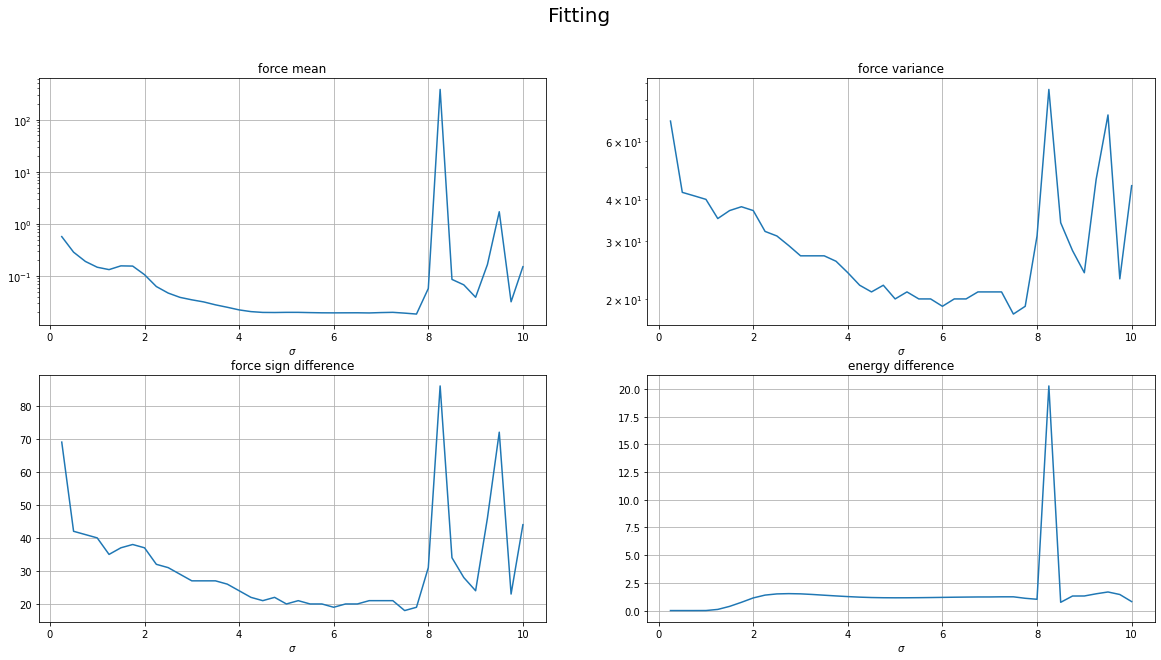

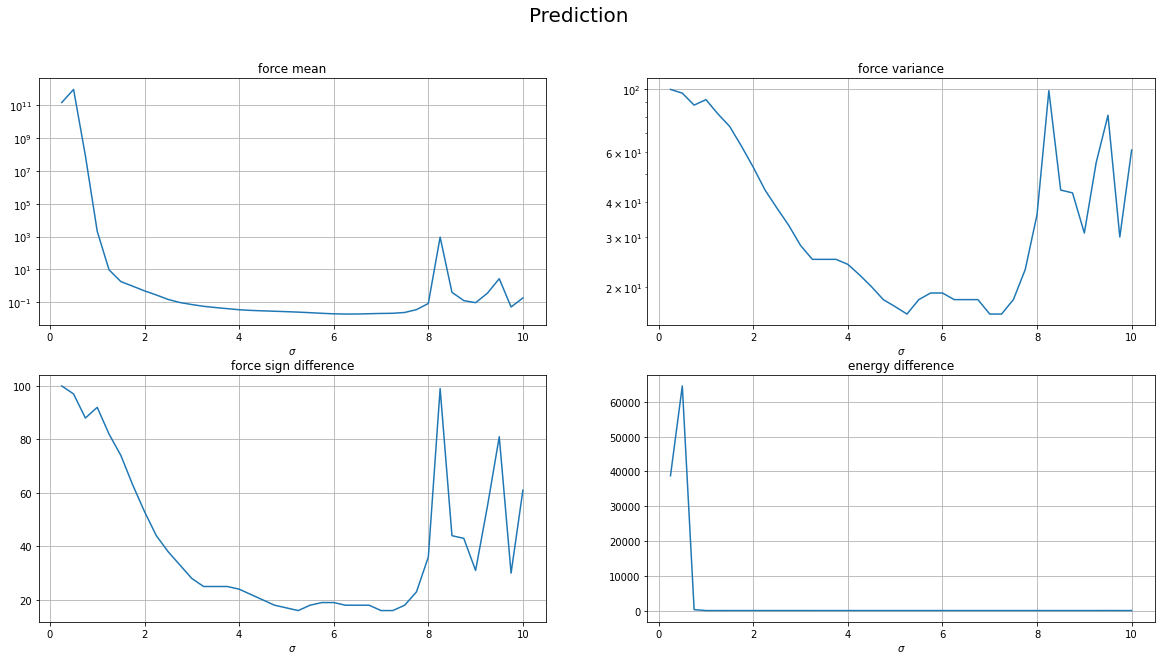

In [190]:
analyze(100, 10, 0.25, max_n = 40)

steps     =  100
stepsize  = 0.01
max sigma =  1.0
modi      =   10

Minimize values in fitting
sigma     |mean      |var       |signs     |energy    |
  1.000000|  0.822940|  0.147540| 40.000000|  0.003443|
  1.000000|  0.822940|  0.147540| 40.000000|  0.003443|
  0.840000|  0.847595|  0.170432| 39.000000|  0.000055|
  0.090000|  1.374669|  0.653968| 80.000000|  0.000000|


Minimize values in prediction
sigma     |mean      |var       |signs     |energy    |
  0.100000|  1.324759|  0.525093| 89.000000|  0.722826|
  0.090000|  1.353086|  0.510562|109.000000|  0.721726|
  0.370000|575556.924955|652613572035.826660| 83.000000|10830.810375|
  0.090000|  1.353086|  0.510562|109.000000|  0.721726|


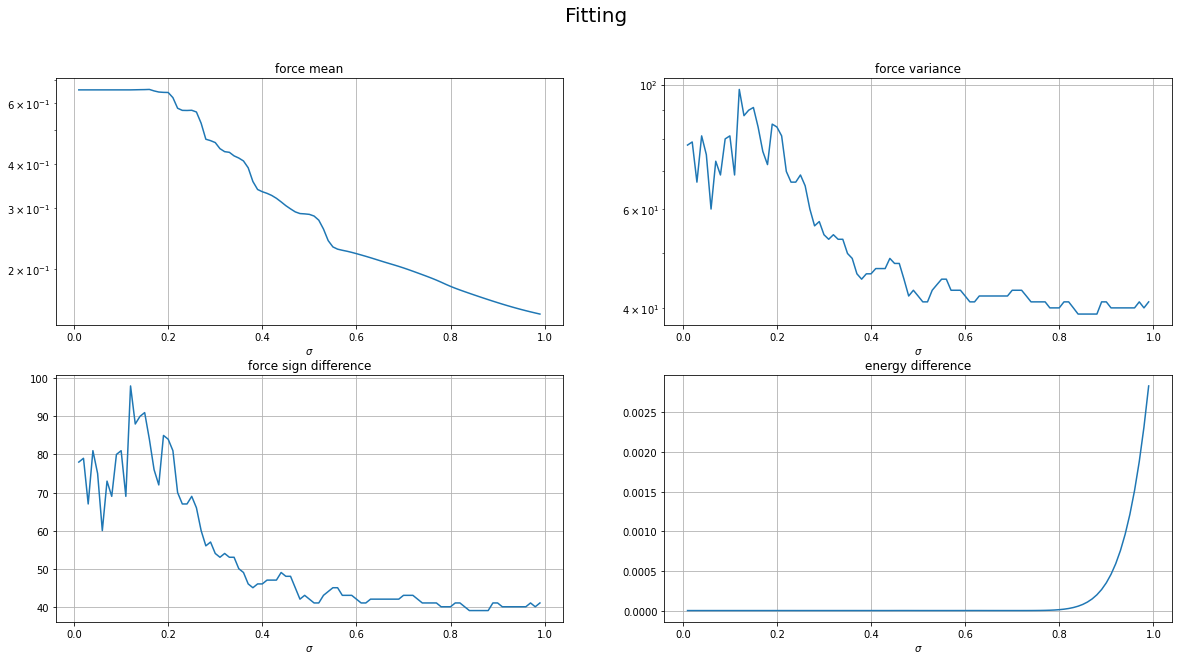

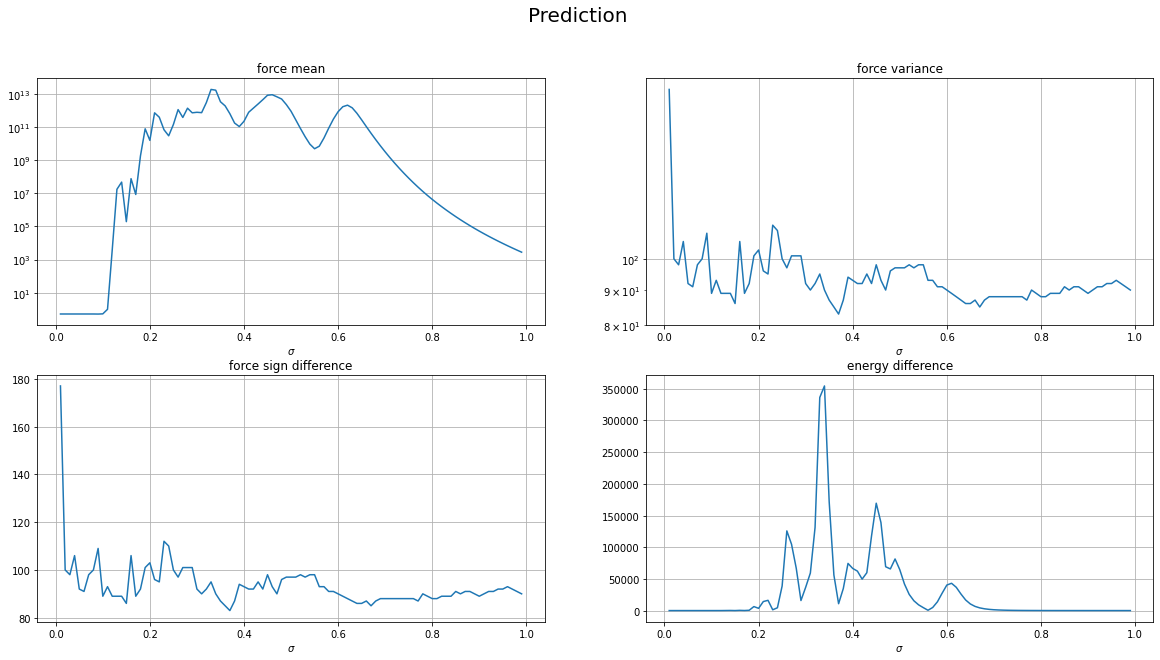

In [184]:
analyze(100, 10, 0.01)

steps     =  100
stepsize  =0.0001
max sigma = 0.01
modi      =   10

Minimize values in fitting
sigma     |mean      |var       |signs     |energy    |
  0.000100|  1.102577|  0.273904| 63.000000|  0.000000|
  0.000100|  1.102577|  0.273904| 63.000000|  0.000000|
  0.005400|  1.374669|  0.653967| 51.000000|  0.000000|
  0.009700|  1.374669|  0.653968| 68.000000|  0.000000|


Minimize values in prediction
sigma     |mean      |var       |signs     |energy    |
  0.000100|  1.339444|  0.515352|192.000000|  0.721887|
  0.000100|  1.339444|  0.515352|192.000000|  0.721887|
  0.009700|  1.339444|  0.515352|175.000000|  0.721887|
  0.000100|  1.339444|  0.515352|192.000000|  0.721887|


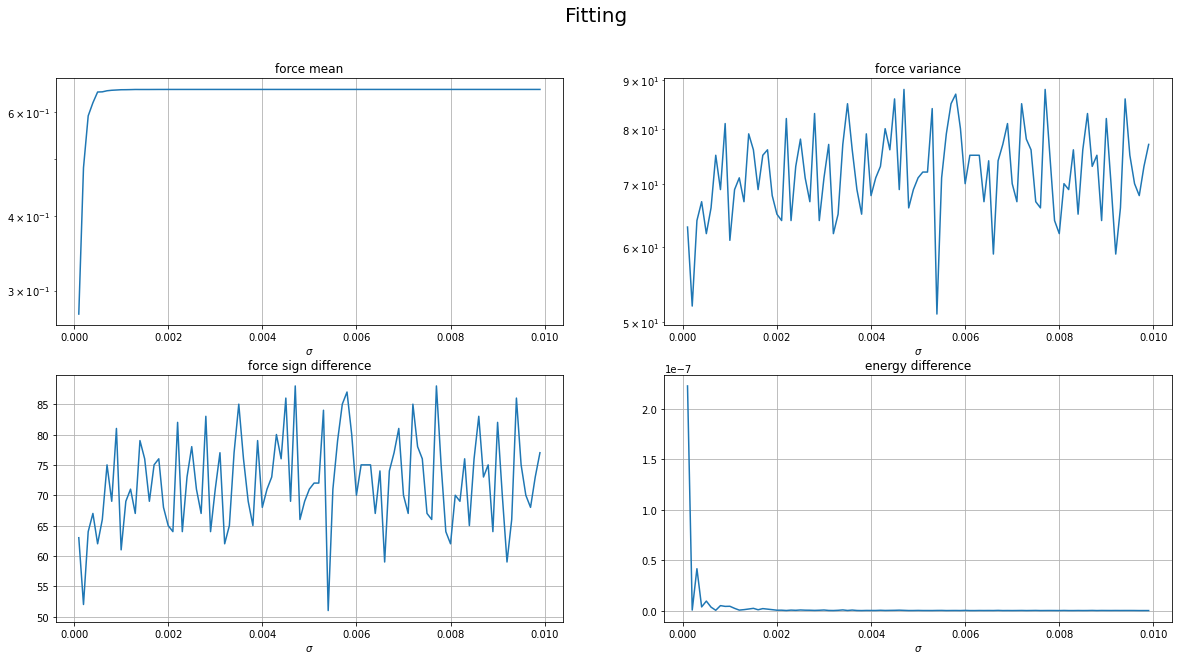

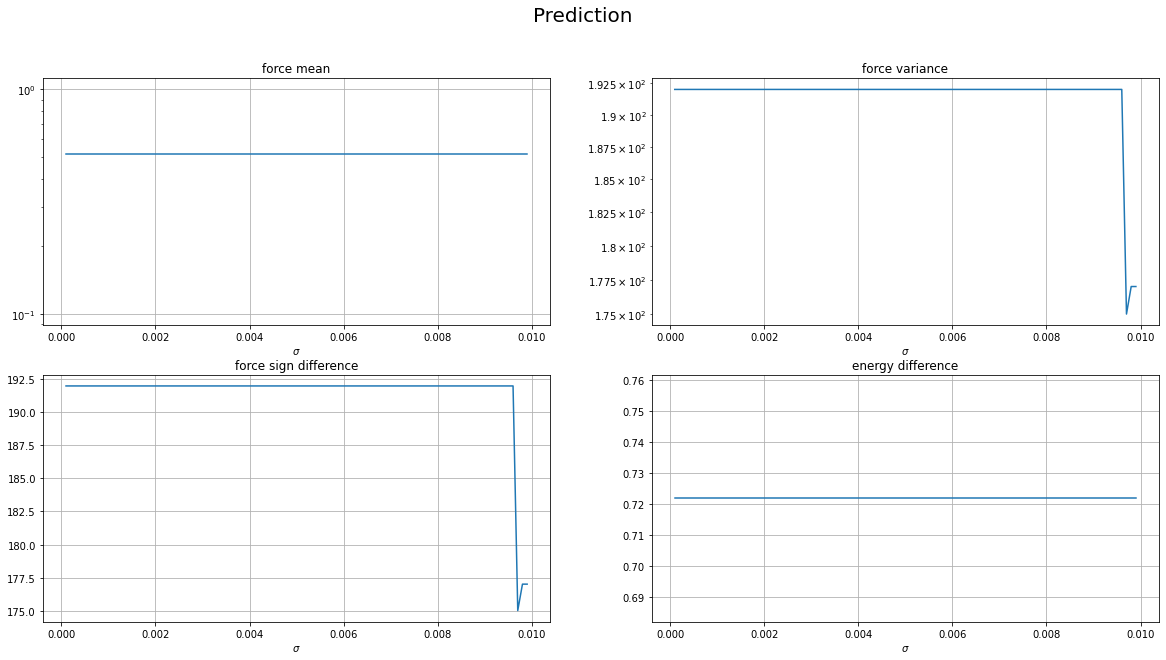

In [189]:
analyze(100, 10, 0.0001)

steps     =  100
stepsize  = 0.25
max sigma = 25.0
modi      =    8

Minimize values in fitting
sigma     |mean      |var       |signs     |energy    |
  3.750000|  0.338386|  0.021186| 20.000000|  1.192171|
  3.000000|  0.364285|  0.017904| 20.000000|  1.118452|
  4.750000|  0.341423|  0.019385| 18.000000|  1.190128|
  0.250000|  1.062581|  0.364288| 54.000000|  0.000000|


Minimize values in prediction
sigma     |mean      |var       |signs     |energy    |
  4.000000|  0.398907|  0.024295| 22.000000|  0.940682|
  4.750000|  0.399871|  0.023218| 22.000000|  0.914314|
  3.250000|  0.421429|  0.030523| 19.000000|  0.931313|
  1.000000|  1.839488|  1.438095| 63.000000|  0.199980|


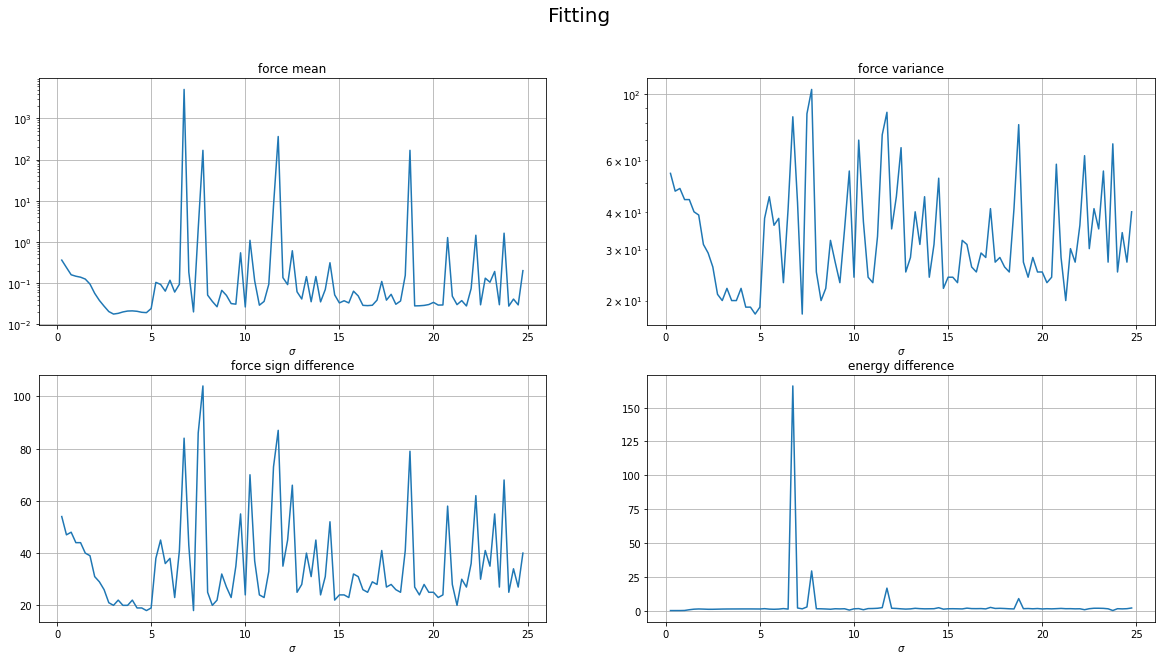

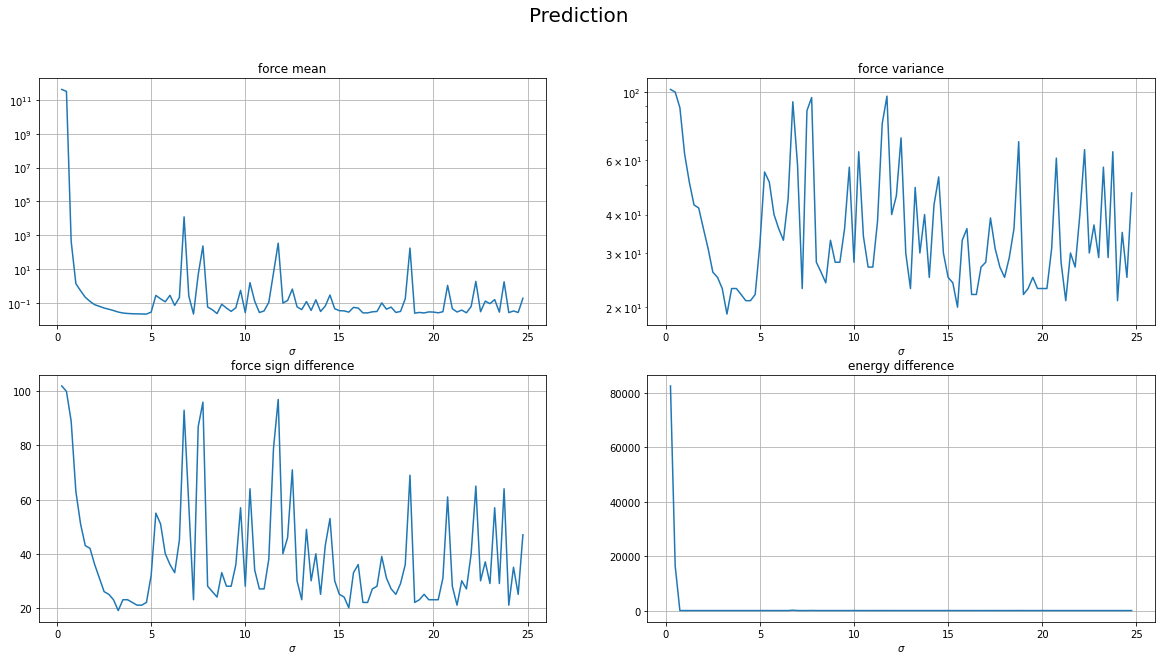

In [185]:
analyze(100, 8)

steps     =  100
stepsize  = 0.25
max sigma = 25.0
modi      =    6

Minimize values in fitting
sigma     |mean      |var       |signs     |energy    |
  2.500000|  0.383803|  0.023450| 26.000000|  1.007667|
  2.250000|  0.391055|  0.023092| 26.000000|  0.990064|
 16.500000|  0.429482|  0.033884| 21.000000|  1.442634|
  0.250000|  0.913349|  0.134463| 54.000000|  0.000000|


Minimize values in prediction
sigma     |mean      |var       |signs     |energy    |
 22.500000|  0.417691|  0.031709| 21.000000|  1.166642|
 11.000000|  0.467988|  0.022327| 24.000000|  1.033547|
 22.500000|  0.417691|  0.031709| 21.000000|  1.166642|
  0.750000|  1.826588|  1.169881| 71.000000|  0.190462|


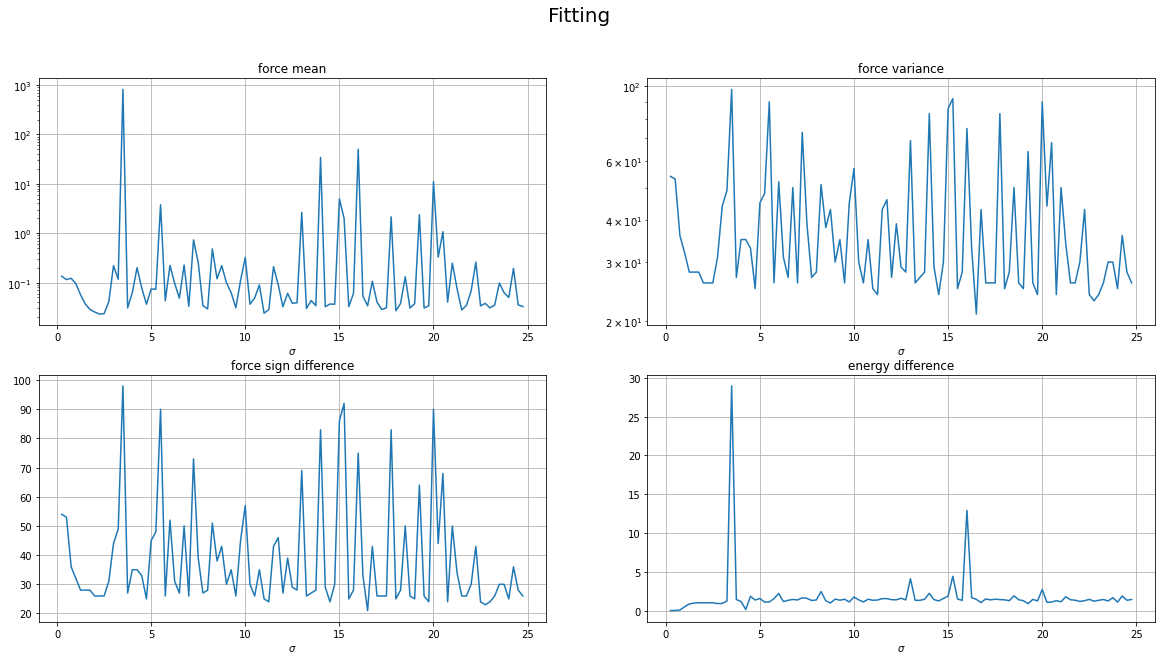

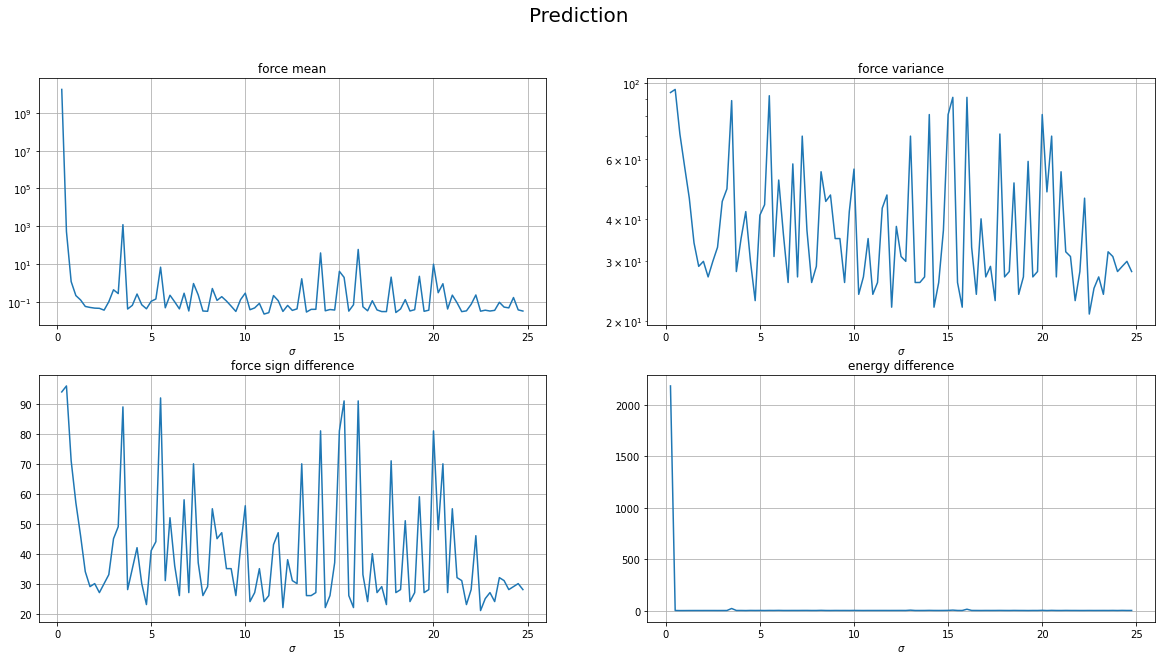

In [186]:
analyze(100, 6)

steps     =  100
stepsize  = 0.25
max sigma = 25.0
modi      =    4

Minimize values in fitting
sigma     |mean      |var       |signs     |energy    |
  1.000000|  0.412368|  0.022587| 28.000000|  0.705054|
  1.000000|  0.412368|  0.022587| 28.000000|  0.705054|
 12.500000|  0.505384|  0.052199| 24.000000|  1.302935|
  0.250000|  0.975394|  0.224358| 56.000000|  0.008665|


Minimize values in prediction
sigma     |mean      |var       |signs     |energy    |
  2.750000|  0.464598|  0.033706| 27.000000|  0.952488|
 10.750000|  0.479483|  0.033256| 28.000000|  0.996638|
  6.250000|  0.494276|  0.046926| 25.000000|  0.959531|
  1.500000|  1.943684|  1.536947| 69.000000|  0.060001|


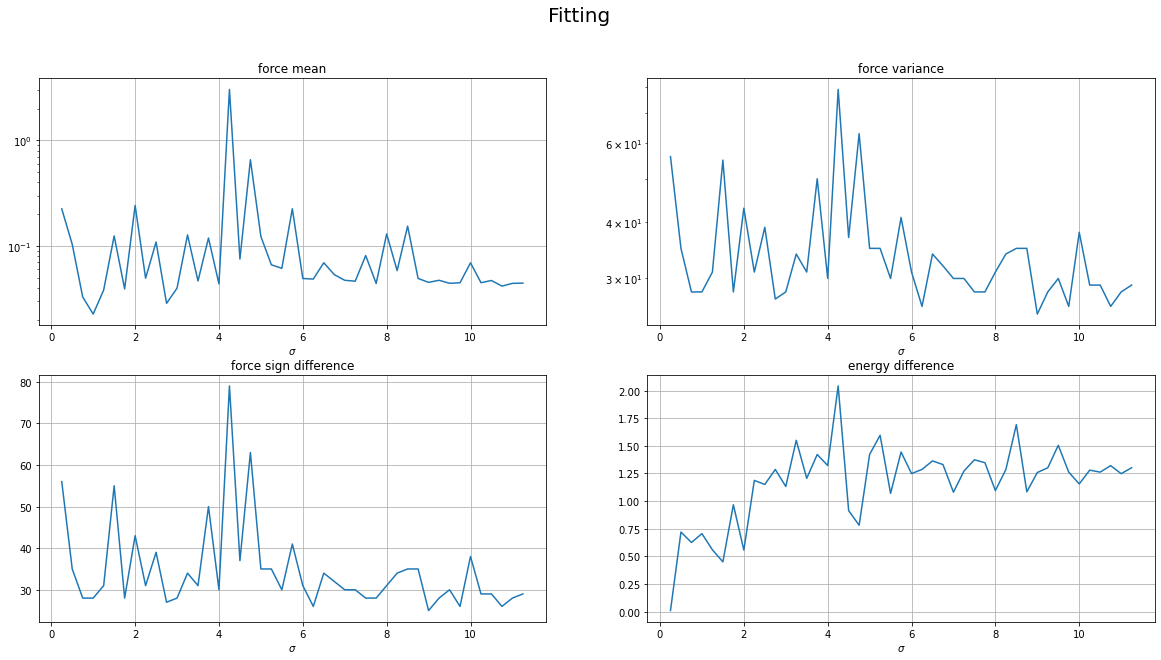

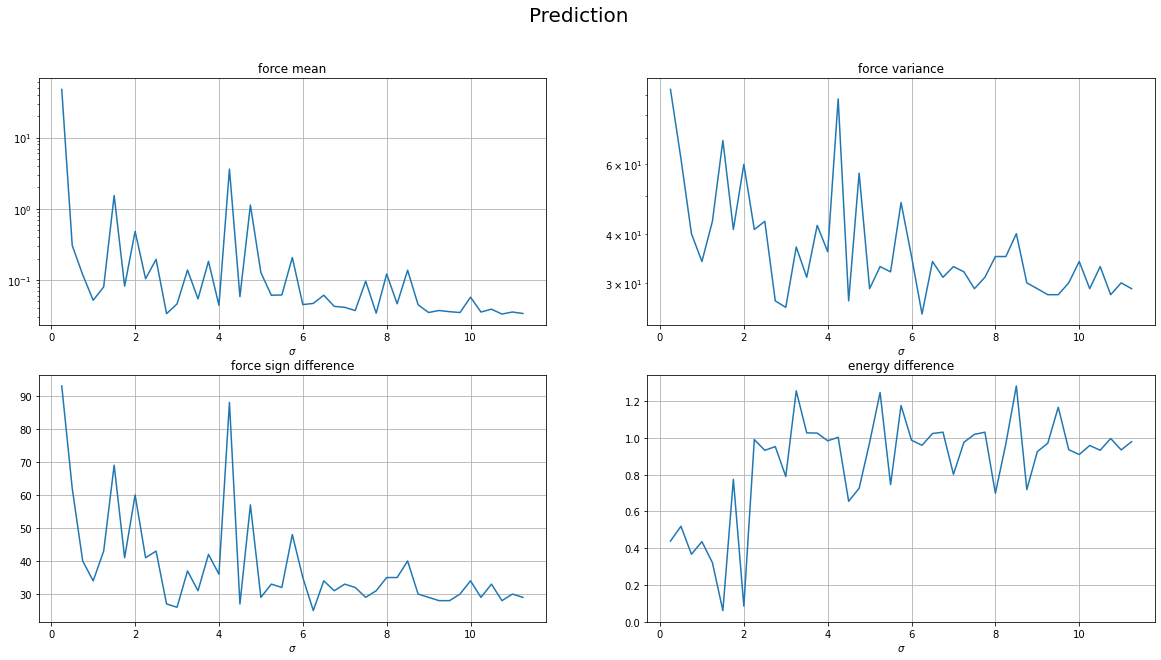

In [187]:
analyze(100, 4, max_n=45)

In [188]:
analyze(100, 12)

steps     =  100
stepsize  = 0.25
max sigma = 25.0
modi      =   12

Minimize values in fitting
sigma     |mean      |var       |signs     |energy    |
 10.500000|  0.328875|  0.020397| 19.000000|
  7.500000|  0.334500|  0.016702| 18.000000|
  7.250000|  0.335221|  0.016755| 16.000000|


IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
analyze(100, 12, 0.01)

In [ ]:
analyze(100, 10, 0.01)

In [ ]:
analyze(100, 10, 0.0001)

In [ ]:
analyze(100, 10, 0.000001)

In [ ]:
analyze(100, 14, 0.25)